In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from scipy.signal import savgol_filter, butter, filtfilt
from scipy import signal
from scipy.optimize import curve_fit
from scipy.fft import fft
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.signal import hilbert
from matplotlib.collections import LineCollection
import pywt
from tqdm.auto import tqdm
import numpy as np
import math
load_dotenv()

from tokenizers import SentencePieceBPETokenizer
import transformers
from transformers import AutoTokenizer
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM

from torch.utils.data import Dataset
from typing import Dict

import os
import warnings
warnings.filterwarnings('ignore')

import torch
torch.cuda.is_available()

False

В данном разделе рассмотрим фильтрацию и кодирование ```ЭКГ-сигнала``` и обучим модель для ```Masked Langiage Modelling```

Считываем все сигналы

In [184]:
second_ecg = pd.read_csv(os.environ['ECG_DATA_PATH_SECOND'], delimiter='\t', encoding='cp1251')
third_ecg = pd.read_csv(os.environ['ECG_DATA_PATH_THIRD'], delimiter='\t', encoding='cp1251', 
										header=None, names=[f'column_{i}' for i in range(16)])
fourth_ecg = pd.read_csv(os.environ['ECG_DATA_PATH_FOURTH'], delimiter='\t', encoding='cp1251', 
                         header=None, names=[f'column_{i}' for i in range(16)])

reo_preprocessed_first = pd.read_csv(os.environ['ECG_DATA_PATH_FIRST_REO_PREPROCESSED'])
reo_preprocessed_second = pd.read_csv(os.environ['ECG_DATA_PATH_SECOND_REO_PREPROCESSED'])
reo_preprocessed_third = pd.read_csv(os.environ['ECG_DATA_PATH_THIRD_REO_PREPROCESSED'])
reo_preprocessed_fourth = pd.read_csv(os.environ['ECG_DATA_PATH_FOURTH_REO_PREPROCESSED'])

reo_preprocessed_first.head()

,"ПРКГ(3), мОм","ПРКГ(5), мОм","ПРКГ(7), мОм","ПРКГ(9), мОм","ПРКГ(13), мОм","ПРКГ(15), мОм","ЭКГ(16), мкВ","ПРКГ(18), мОм","ПРКГ(19), мОм","ПРКГ(20), мОм",...,Unnamed: 15,smoothed_ma,smoothed_ema,median_filtered,haar_wavelet,db_wavelet,butterworth_filtered,derivative_signal,label,name
0,-2.4,-2.4,-2.4,-2.8,-2.4,-2.8,12.986,-2.4,-1.2,-2.8,...,NaN,-2.000000,-2.000000,-10.4,-8.982031,-17.947907,-22.132034,-0.010325,0,exhale
1,-2.4,-2.8,-2.8,-2.8,-2.4,-2.8,5.565,-2.4,-1.2,-2.4,...,NaN,-2.000000,-2.000000,-10.4,-8.982031,-17.902574,-22.142358,-0.010329,0,exhale
2,-2.4,-3.2,-2.8,-2.8,-1.6,-2.4,-3.710,-1.6,-0.4,-1.6,...,NaN,-2.133333,-2.134002,-10.4,-8.982031,-17.857220,-22.152692,-0.010338,0,exhale
3,-2.4,-3.2,-3.2,-2.8,-0.4,-2.0,-7.420,-0.4,0.0,-0.8,...,NaN,-2.300000,-2.301756,-10.4,-8.982031,-17.811847,-22.163035,-0.010347,0,exhale
4,-2.8,-3.6,-4.0,-2.4,0.4,-1.6,-3.710,0.8,0.8,0.0,...,NaN,-2.480000,-2.483210,-10.4,-8.982031,-17.766455,-22.173387,-0.010356,0,exhale


In [185]:
second_ecg.head()

,"ПРКГ(3), мОм","ПРКГ(5), мОм","ПРКГ(7), мОм","ПРКГ(9), мОм","ПРКГ(13), мОм","ПРКГ(15), мОм","ЭКГ(16), мкВ","ПРКГ(18), мОм","ПРКГ(19), мОм","ПРКГ(20), мОм","ПРКГ(22), мОм","ПРКГ(24), мОм","ПРКГ(26), мОм","ПРКГ(30), мОм","ТРКГ(32), мОм",Unnamed: 15
0,-2.8,-2.8,-2.8,-2.8,-2.8,-2.8,12.986,-2.8,-2.8,-2.8,-2.8,-2.8,-2.8,-2.8,-3.2,NaN
1,-2.8,-2.8,-2.8,-2.8,-2.8,-2.8,24.116,-2.8,-2.8,-2.8,-2.8,-2.8,-2.8,-2.8,-3.2,NaN
2,-2.8,-3.2,-2.8,-2.8,-2.8,-2.4,33.392,-2.8,-2.8,-2.4,-2.4,-2.8,-2.8,-2.8,-3.6,NaN
3,-2.8,-3.6,-2.8,-2.8,-3.2,-2.4,27.827,-3.2,-3.2,-2.0,-2.4,-2.8,-2.8,-3.2,-4.0,NaN
4,-2.8,-4.4,-2.8,-2.8,-3.6,-2.8,20.406,-3.6,-3.2,-2.0,-2.4,-2.8,-2.8,-2.8,-4.8,NaN


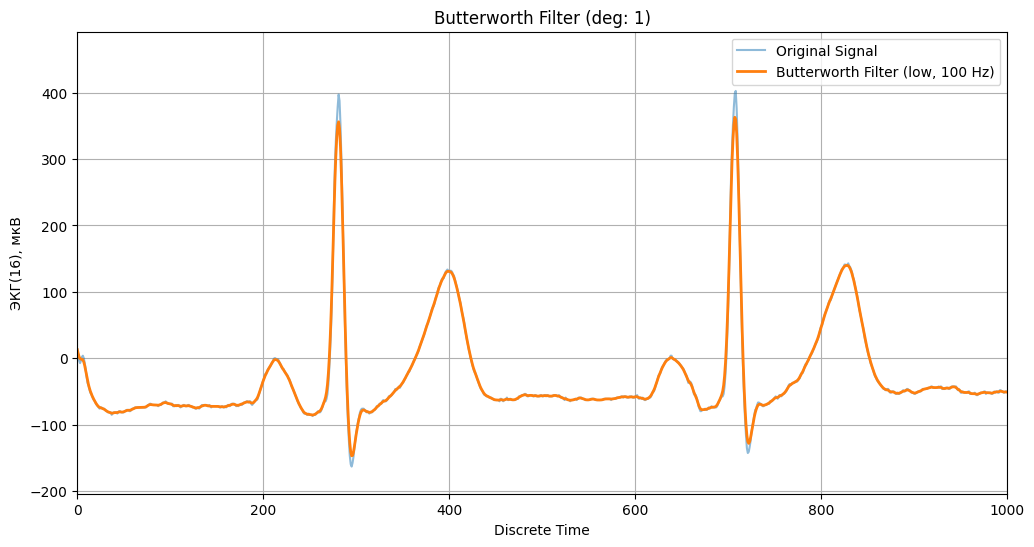

In [186]:
def butterworth_filter_df(df, column, cutoff, fs, order=5, filter_type='low',
                         plot=False, x_column=None, xlim=None, ylim=None, figsize=(12, 6)):
    """
    Фильтрация сигнала из DataFrame фильтром Баттерворта
    
    Параметры:
    df - DataFrame с данными
    column - название колонки с сигналом
    cutoff - частота среза (Гц)
    fs - частота дискретизации (Гц)
    order - порядок фильтра
    filter_type - тип фильтра ('low', 'high', 'band')
    plot - отображать график
    x_column - название колонки с x-значениями
    xlim - пределы по оси X
    ylim - пределы по оси Y
    figsize - размер графика
    
    Возвращает:
    df с добавленной колонкой 'butterworth_filtered'
    """
    data = df[column].values
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    
    b, a = signal.butter(order, normal_cutoff, btype=filter_type, analog=False)
    df['butterworth_filtered_ecg'] = signal.filtfilt(b, a, data)
    
    if plot:
        x = df[x_column].values if x_column else df.index.values
        plt.figure(figsize=figsize)
        plt.plot(x, data, label='Original Signal', alpha=0.5)
        plt.plot(x, df['butterworth_filtered_ecg'], 
                label=f'Butterworth Filter ({filter_type}, {cutoff} Hz)', 
                linewidth=2)
        plt.legend()
        plt.grid(True)
        if xlim: plt.xlim(*xlim)
        if ylim: plt.ylim(*ylim)
        plt.title(f'Butterworth Filter (deg: {order})')
        plt.xlabel(x_column if x_column else 'Discrete Time')
        plt.ylabel(column)
        plt.show()
    
    return df


reo_preprocessed = butterworth_filter_df(df=reo_preprocessed_first,
                                           column='ЭКГ(16), мкВ',
                                           order=1,
                                           fs=1000,
                                           cutoff=100,
                                           plot=True,
                                           xlim=[0, 1000])

reo_preprocessed_second = butterworth_filter_df(df=reo_preprocessed_second,
                                           column='ЭКГ(16), мкВ',
                                           order=1,
                                           fs=1000,
                                           cutoff=100,
                                           plot=False,
                                           xlim=[0, 1000])

reo_preprocessed_third = butterworth_filter_df(df=reo_preprocessed_third,
                                           column='column_6',
                                           order=1,
                                           fs=1000,
                                           cutoff=100,
                                           plot=False,
                                           xlim=[0, 1000])

reo_preprocessed_fourth = butterworth_filter_df(df=reo_preprocessed_fourth,
                                           column='column_6',
                                           order=1,
                                           fs=1000,
                                           cutoff=100,
                                           plot=False,
                                           xlim=[0, 1000])


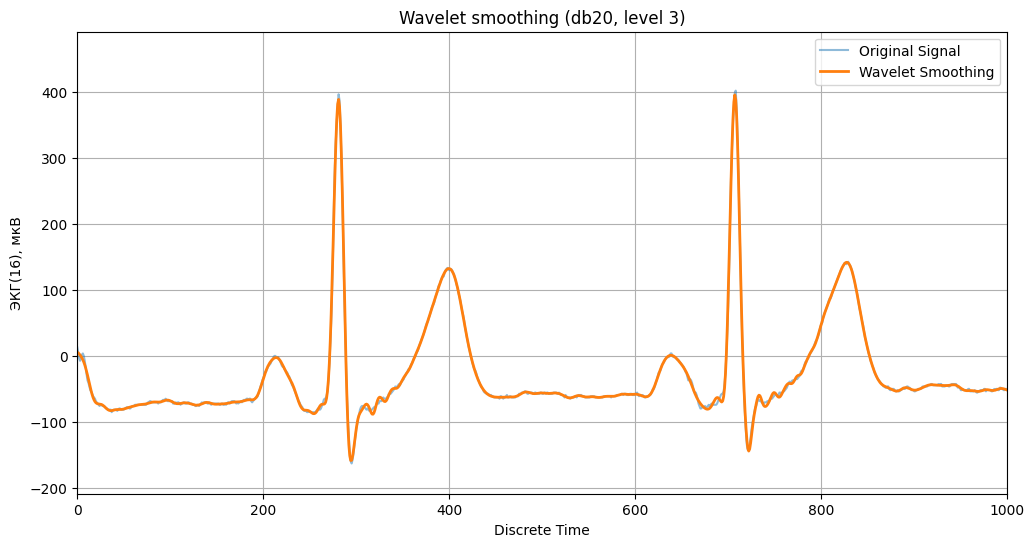

In [187]:
def wavelet_denoising_df(df, column, wavelet='haar', level=3, threshold_type='soft', 
                        plot=False, x_column=None, xlim=None, ylim=None, figsize=(12, 6), 
                        column_new = 'haar_wavelet'):
    """
    Вейвлет-сглаживание сигнала из DataFrame
    
    Параметры:
    df - DataFrame с данными
    column - название колонки с сигналом
    wavelet - тип вейвлета
    level - уровень декомпозиции
    threshold_type - тип порога ('soft' или 'hard')
    plot - отображать график
    x_column - название колонки с x-значениями
    xlim - пределы по оси X
    ylim - пределы по оси Y
    figsize - размер графика
    
    Возвращает:
    df с добавленной колонкой 'wavelet_denoised'
    """
    data = df[column].values
    
    coeffs = pywt.wavedec(data, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode=threshold_type) for c in coeffs[1:]]
    
    smoothed = pywt.waverec(coeffs, wavelet)
    df[column_new] = smoothed[:len(data)]
    
    if plot:
        x = df[x_column].values if x_column else df.index.values
        plt.figure(figsize=figsize)
        plt.plot(x, data, label='Original Signal', alpha=0.5)
        plt.plot(x, df[column_new], label='Wavelet Smoothing', linewidth=2)
        plt.legend()
        plt.grid(True)
        if xlim: plt.xlim(*xlim)
        if ylim: plt.ylim(*ylim)
        plt.title(f'Wavelet smoothing ({wavelet}, level {level})')
        plt.xlabel(x_column if x_column else 'Discrete Time')
        plt.ylabel(column)
        plt.show()
    
    return df

reo_preprocessed_first = wavelet_denoising_df(df=reo_preprocessed_first,
                                           column='ЭКГ(16), мкВ',
                                           column_new='daubechy_wavelet_ecg',
                                            wavelet='db20',
                                            level=3,
                                           plot=True,
                                           xlim=[0, 1000])

reo_preprocessed_second = wavelet_denoising_df(df=reo_preprocessed_second,
                                           column='ЭКГ(16), мкВ',
                                           column_new='daubechy_wavelet_ecg',
                                            wavelet='db20',
                                            level=3,
                                           plot=False,
                                           xlim=[0, 1000])

reo_preprocessed_third = wavelet_denoising_df(df=reo_preprocessed_third,
                                           column='column_6',
                                           column_new='daubechy_wavelet_ecg',
                                            wavelet='db20',
                                            level=3,
                                           plot=False,
                                           xlim=[0, 1000])

reo_preprocessed_fourth = wavelet_denoising_df(df=reo_preprocessed_fourth,
                                           column='column_6',
                                           column_new='daubechy_wavelet_ecg',
                                            wavelet='db20',
                                            level=3,
                                           plot=False,
                                           xlim=[0, 1000])

In [188]:
reo_preprocessed.head()

,"ПРКГ(3), мОм","ПРКГ(5), мОм","ПРКГ(7), мОм","ПРКГ(9), мОм","ПРКГ(13), мОм","ПРКГ(15), мОм","ЭКГ(16), мкВ","ПРКГ(18), мОм","ПРКГ(19), мОм","ПРКГ(20), мОм",...,smoothed_ema,median_filtered,haar_wavelet,db_wavelet,butterworth_filtered,derivative_signal,label,name,butterworth_filtered_ecg,daubechy_wavelet_ecg
0,-2.4,-2.4,-2.4,-2.8,-2.4,-2.8,12.986,-2.4,-1.2,-2.8,...,-2.000000,-10.4,-8.982031,-17.947907,-22.132034,-0.010325,0,exhale,12.904811,5.678329
1,-2.4,-2.8,-2.8,-2.8,-2.4,-2.8,5.565,-2.4,-1.2,-2.4,...,-2.000000,-10.4,-8.982031,-17.902574,-22.142358,-0.010329,0,exhale,7.023216,4.541021
2,-2.4,-3.2,-2.8,-2.8,-1.6,-2.4,-3.710,-1.6,-0.4,-1.6,...,-2.134002,-10.4,-8.982031,-17.857220,-22.152692,-0.010338,0,exhale,2.048932,3.084357
3,-2.4,-3.2,-3.2,-2.8,-0.4,-2.0,-7.420,-0.4,0.0,-0.8,...,-2.301756,-10.4,-8.982031,-17.811847,-22.163035,-0.010347,0,exhale,-0.863212,1.339581
4,-2.8,-3.6,-4.0,-2.4,0.4,-1.6,-3.710,0.8,0.8,0.0,...,-2.483210,-10.4,-8.982031,-17.766455,-22.173387,-0.010356,0,exhale,-1.555472,-0.711325


Сравним два фильтра

In [7]:
import antropy as ant

spectral_entropy_original = ant.spectral_entropy(reo_preprocessed['ЭКГ(16), мкВ'], sf=600, method='welch', normalize=True)
spectral_entropy_butterworth = ant.spectral_entropy(reo_preprocessed['butterworth_filtered_ecg'], sf=600, method='welch', normalize=True)
spectral_entropy_wav = ant.spectral_entropy(reo_preprocessed['daubechy_wavelet_ecg'], sf=600, method='welch', normalize=True)

sample_entropy_original = ant.sample_entropy(reo_preprocessed['ЭКГ(16), мкВ'])
sample_entropy_butterworth = ant.sample_entropy(reo_preprocessed['butterworth_filtered_ecg'])
sample_entropy_wav = ant.sample_entropy(reo_preprocessed['daubechy_wavelet_ecg'])

entropy_dict = {'spectral_entropy': [
					spectral_entropy_original, 
					spectral_entropy_butterworth,
                    spectral_entropy_wav
                ], 
                'sample_entropy': [
					sample_entropy_original,
                    sample_entropy_butterworth, 
                    sample_entropy_wav,
				]}

indices = [
    'Original', 
    'Butterworth',
    'Daubechy Wavelet'
]


result_entropy_df = pd.DataFrame(index=indices, 
                                 data=entropy_dict)

result_entropy_df['entropy_product'] = result_entropy_df['sample_entropy'] * result_entropy_df['spectral_entropy']
result_entropy_df

,spectral_entropy,sample_entropy,entropy_product
Original,0.511865,0.057350,0.029355
Butterworth,0.494629,0.046411,0.022956
Daubechy Wavelet,0.508388,0.052318,0.026598


Будем тогда использовать Фильтр ```Баттерворта```

Преобразуем сигнал: 

1. Нормализация ```(MinMax Scaling)```

In [189]:
reo_preprocessed_second.head()

,"ПРКГ(3), мОм","ПРКГ(5), мОм","ПРКГ(7), мОм","ПРКГ(9), мОм","ПРКГ(13), мОм","ПРКГ(15), мОм","ЭКГ(16), мкВ","ПРКГ(18), мОм","ПРКГ(19), мОм","ПРКГ(20), мОм",...,smoothed_ema,median_filtered,haar_wavelet,db_wavelet,butterworth_filtered,derivative_signal,label,name,butterworth_filtered_ecg,daubechy_wavelet_ecg
0,-2.8,-2.8,-2.8,-2.8,-2.8,-2.8,12.986,-2.8,-2.8,-2.8,...,-3.200000,-23.6,-13.543359,-52.378143,-8.954781,0.012888,1,inhale,12.445334,23.056392
1,-2.8,-2.8,-2.8,-2.8,-2.8,-2.8,24.116,-2.8,-2.8,-2.8,...,-3.200000,-23.6,-13.543359,-52.326371,-8.941893,0.012894,1,inhale,17.352100,23.248169
2,-2.8,-3.2,-2.8,-2.8,-2.8,-2.4,33.392,-2.8,-2.8,-2.4,...,-3.334002,-23.6,-13.543359,-52.274175,-8.928994,0.012905,1,inhale,19.284222,24.029339
3,-2.8,-3.6,-2.8,-2.8,-3.2,-2.4,27.827,-3.2,-3.2,-2.0,...,-3.501756,-23.6,-13.543359,-52.221553,-8.916083,0.012917,1,inhale,16.307296,23.256794
4,-2.8,-4.4,-2.8,-2.8,-3.6,-2.8,20.406,-3.6,-3.2,-2.0,...,-3.764014,-23.6,-13.543359,-52.168507,-8.903160,0.012928,1,inhale,8.110575,18.353686


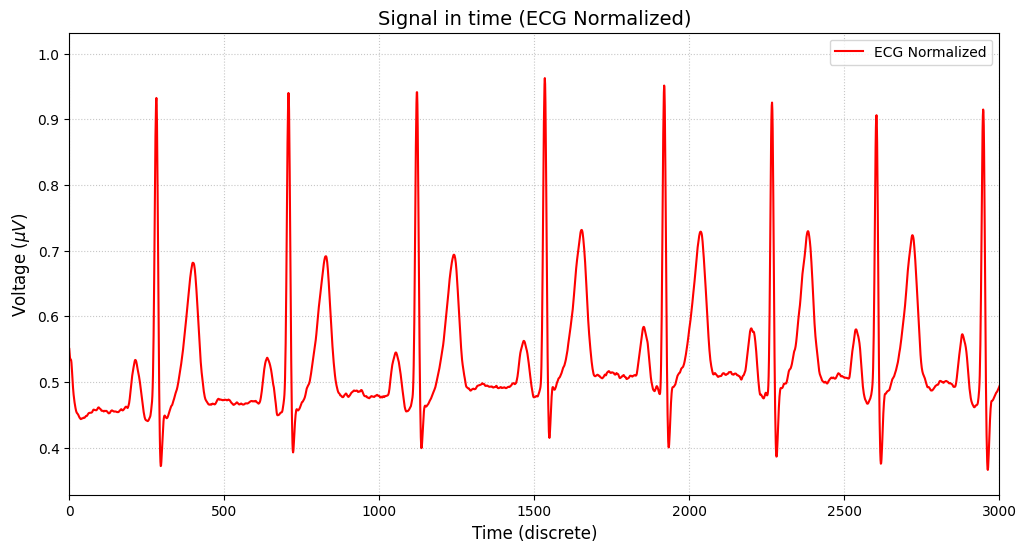

In [190]:
signal_ecg_first = reo_preprocessed_first['butterworth_filtered_ecg'].values
signal_reo_first = reo_preprocessed_first['butterworth_filtered'].values

signal_ecg_second = reo_preprocessed_second['butterworth_filtered_ecg'].values
signal_reo_second = reo_preprocessed_second['butterworth_filtered'].values

signal_ecg_third = reo_preprocessed_third['butterworth_filtered_ecg'].values
signal_reo_third = reo_preprocessed_third['butterworth_filtered'].values

signal_ecg_fourth = reo_preprocessed_fourth['butterworth_filtered_ecg'].values
signal_reo_fourth = reo_preprocessed_fourth['butterworth_filtered'].values


all_signals = np.concatenate([
    signal_ecg_first,
	signal_ecg_second,
	signal_ecg_third,
	signal_ecg_fourth
])

global_min = np.min(all_signals)
global_max = np.max(all_signals)

normalized_signal_ecg_first = (signal_ecg_first - global_min) / (global_max - global_min)
normalized_reo_first = (signal_reo_first - np.min(signal_reo_first)) / (np.max(signal_reo_first) - np.min(signal_reo_first))

normalized_signal_ecg_second = (signal_ecg_second - global_min) / (global_max - global_min)
normalized_reo_second = (signal_reo_second - np.min(signal_reo_second)) / (np.max(signal_reo_second) - np.min(signal_reo_second))

normalized_signal_ecg_third = (signal_ecg_third - global_min) / (global_max - global_min)
normalized_reo_third = (signal_reo_third - np.min(signal_reo_third)) / (np.max(signal_reo_third) - np.min(signal_reo_third))

normalized_signal_ecg_fourth = (signal_ecg_fourth - global_min) / (global_max - global_min)
normalized_reo_fourth = (signal_reo_fourth - np.min(signal_reo_fourth)) / (np.max(signal_reo_fourth) - np.min(signal_reo_fourth))

all_normalized_signals = [
	normalized_signal_ecg_first, 
	normalized_signal_ecg_second,
	normalized_signal_ecg_third,
	normalized_signal_ecg_fourth,
]

def plot_signals(signal, label, lower_time_limit = 0, upper_time_limit = 1000, color = 'red'):
	plt.figure(figsize=(12, 6))
	plt.plot(signal, label=label, color=color, linewidth=1.5)
	plt.title(f'Signal in time ({label})', fontsize=14)
	plt.xlabel('Time (discrete)', fontsize=12)
	plt.ylabel('Voltage ($\mu V$)', fontsize=12)
	plt.legend(fontsize=10)
	plt.grid(True, linestyle=':', alpha=0.7)
	plt.xlim([lower_time_limit, upper_time_limit])
	plt.xlim([lower_time_limit, upper_time_limit])
	plt.show()

plot_signals(signal = normalized_signal_ecg_first, 
			label='ECG Normalized', upper_time_limit=3000)


Следующим шагом является ```квантизация``` и ```кодирование``` сигнала ```ЭКГ```

Класс квантизатора

In [10]:
class DiffQuantizer:
    def __init__(self, alphabet_size, average_over=1, filter=False, breakpoints=None, use_diffs=True):
        self.alphabet_size = alphabet_size
        self.average_over = average_over
        self.use_filter = filter
        self.breakpoints = breakpoints
        self.use_diffs = use_diffs

    def preprocess(self, tmp):
        if self.average_over != 1:
            tmp = self._average_over_n(tmp, self.average_over)

        if self.use_filter:
            tmp = self._filter_signal(tmp)

        if self.use_diffs:
            tmp = self._diff_signal(tmp)

        return tmp

    def perform_quantization(self, tmp, breakpoints=None):
        self.breakpoints = breakpoints
        tmp = self.preprocess(tmp)
        result = self._quantize_with_breakpoints(tmp)
        return result

    def learn_breakpoints(self, arr):
        res = self.preprocess(arr)

        sorted_array = np.sort(res)

        length = len(sorted_array)

        probs = [1 / self.alphabet_size for _ in range(self.alphabet_size)]
        cum_sum_breakpoints = [int(sum(probs[0:i + 1]) * length - 1) for i in range(len(probs))]
        cum_sum_breakpoint_values = sorted_array[cum_sum_breakpoints]

        cum_sum_breakpoint_values[-1] = 1e+100

        self.breakpoints = cum_sum_breakpoint_values

        return cum_sum_breakpoint_values

    @staticmethod
    def _breakpoint_to_letter(float_num, breakpoints):
        int_val = next((breakpoints.index(obj) for obj in breakpoints if float_num < obj))
        return chr(65 + int_val)

    def _quantize_with_breakpoints(self, tmp):
        breakpoints = self.breakpoints
        vect_breakpoint_to_letter = np.vectorize(self._breakpoint_to_letter, excluded=['breakpoints'])
        tmp = vect_breakpoint_to_letter(tmp, breakpoints=list(breakpoints))
        return tmp

    @staticmethod
    def _read_csv_file(input_file):
        tmp_file_content = pd.read_csv(input_file, sep="\n", header=None, dtype=np.float64)
        return np.array(tmp_file_content)

    @staticmethod
    def _average_over_n(tmp, n):
        return np.array([np.average(tmp[i:i + n]) for i in range(0, len(tmp), n)])

    @staticmethod
    def _diff_signal(tmp):
        res = np.diff(tmp)
        return np.insert(res, 0, 0.0)
    
quantizer = DiffQuantizer(
    alphabet_size=6,  # Кодируем в 8 буквы: A, B, C, D, E, F, G, H
    average_over=1,   # Без усреднения
    filter=False,     # Не фильтруем (сигнал уже отфильтрован)
    use_diffs=False   # Используем разности сигнала
)

breakpoints = quantizer.learn_breakpoints(normalized_signal_ecg_first)
print("Рассчитанные пороги:", breakpoints)

Рассчитанные пороги: [4.84627330e-001 4.92990877e-001 4.99925674e-001 5.20960075e-001
 5.89534767e-001 1.00000000e+100]


Закодированный сигнал

In [27]:
encoded_signal = quantizer.perform_quantization(normalized_signal_ecg_first, breakpoints=breakpoints)
print("Закодированный сигнал:", encoded_signal)

Закодированный сигнал: ['E' 'E' 'E' ... 'C' 'B' 'B']


Квантизация ```Ллойда```

In [28]:
class Preprocessing():
    def __init__(self, discretization_factor, max_window_size):
        self.discretization_factor = discretization_factor
        self.max_window_size = max_window_size

    def create_windows(self, signal):
        """Разбивает сигнал на окна фиксированного размера."""
        signal_length = len(signal)
        window_size = min(self.max_window_size, signal_length)
        num_windows = math.floor(signal_length / window_size)
        
        windows = []
        for i in range(num_windows):
            start = i * window_size
            end = (i + 1) * window_size
            windows.append(signal[start:end])
        
        return windows

    def quantize_signal(self, signal, quantizer):
        """Квантизирует сигнал с помощью заданного квантизатора."""
        quantizer.learn_breakpoints(np.array(signal))
        quantized = quantizer.perform_quantization(np.array(signal), quantizer.breakpoints)
        return ''.join(quantized)

def create_quantizer(signals, alphabet_size):
    """Создает и обучает квантизатор на наборе сигналов."""
    all_data = np.concatenate([np.array(s) for s in signals])
    
    quantizer = DiffQuantizer(
        alphabet_size=alphabet_size,
        breakpoints=None,
        use_diffs=False
    )
    quantizer.learn_breakpoints(all_data)
    return quantizer

def process_single_signal(signal, max_window_size=1250, alphabet_size=6):
    """
    Обрабатывает один сигнал:
    1. Разбивает на окна
    2. Создает квантизатор (если нужно)
    3. Кодирует в символьное представление
    """
    processor = Preprocessing(
        discretization_factor=alphabet_size,
        max_window_size=max_window_size
    )
    
    windows = processor.create_windows(signal)
    quantizer = create_quantizer(windows, alphabet_size)
    encoded_windows = [processor.quantize_signal(w, quantizer) for w in windows]
    
    return encoded_windows, quantizer

Посмотрим на результат кодирования

In [29]:
encoded_windows, quantizer = process_single_signal(
        signal=normalized_signal_ecg_first,
        max_window_size=4000,  
        alphabet_size=100)

In [191]:
all_normalized_signals

[array([0.55016695, 0.54361116, 0.53806667, ..., 0.49318598, 0.49268985,
        0.49234932]),
 array([0.54965481, 0.55512403, 0.55727763, ..., 0.54694473, 0.5505385 ,
        0.55426496]),
 array([0.55023595, 0.5520326 , 0.55344709, ..., 0.6716514 , 0.67600519,
        0.67554019]),
 array([0.55023104, 0.54688442, 0.54414186, ..., 0.58851913, 0.58381635,
        0.57933799])]

Прогоним все сигналы

In [31]:
from typing import List, Tuple

class Preprocessing:
    def __init__(self, discretization_factor: int, max_window_size: int):
        self.discretization_factor = discretization_factor
        self.max_window_size = max_window_size
        self.quantizer = None  #
        
    def create_windows(self, signal: np.ndarray) -> List[np.ndarray]:
        """Разбивает сигнал на окна фиксированного размера."""
        signal_length = len(signal)
        window_size = min(self.max_window_size, signal_length)
        num_windows = math.floor(signal_length / window_size)
        
        return [signal[i*window_size : (i+1)*window_size] 
               for i in range(num_windows)]

    def quantize_signal(self, signal_window: np.ndarray) -> str:
        """Квантизирует окно сигнала с обученным квантизатором."""
        if self.quantizer is None:
            raise ValueError("Quantizer not initialized. Call fit_quantizer() first.")
        quantized = self.quantizer.perform_quantization(signal_window, self.quantizer.breakpoints)
        return ''.join(quantized)

    def fit_quantizer(self, all_signals: List[np.ndarray]):
        """Обучает квантизатор на всех сигналах."""
        all_windows = []
        for signal in all_signals:
            windows = self.create_windows(signal)
            all_windows.extend(windows)
            
        self.quantizer = DiffQuantizer(
            alphabet_size=self.discretization_factor,
            breakpoints=None,
            use_diffs=False
        )
        self.quantizer.learn_breakpoints(np.concatenate(all_windows))

    def process_signals(self, signals: List[np.ndarray]) -> Tuple[List[List[str]], List[np.ndarray]]:
        """
        Основной метод обработки:
        1. Обучает квантизатор на всех сигналах
        2. Разбивает каждый сигнал на окна
        3. Квантизирует окна
        
        Возвращает:
        - encoded_windows: список списков строк (кодированные окна)
        - original_windows: список массивов (оригинальные окна)
        """
        self.fit_quantizer(signals)
        
        encoded_windows = []
        original_windows = []
        
        for signal in signals:
            windows = self.create_windows(signal)
            original_windows.extend(windows)
            encoded_windows.append([self.quantize_signal(w) for w in windows])
            
        return encoded_windows, original_windows

processor = Preprocessing(
    discretization_factor=100,
    max_window_size=1080
)

encoded_windows, original_windows = processor.process_signals(all_normalized_signals)

In [32]:
len(encoded_windows[0][1])

1080

Ок, далее есть смысл запустить обучение задачи ```Masked Language Modelling, ``` для обучения ```LLM``` различать информацию на ```ЭКГ```

In [33]:
len(encoded_signal)

240663

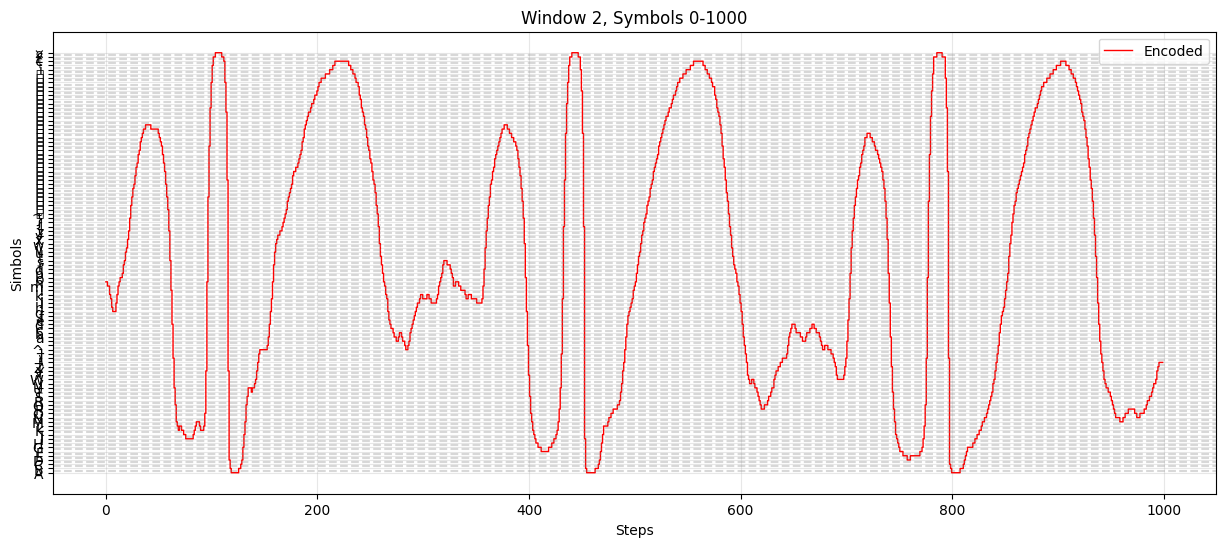

In [34]:
def plot_quantization(original_signal, encoded_window, quantizer, signal_idx=0, window_idx=0, start=0, end=1000):
    """
    Визуализирует результат квантизации для выбранного окна.
    
    Параметры:
        original_signal: Исходный сигнал (полный).
        encoded_window: Закодированные окна (список строк).
        quantizer: Обученный квантизатор.
        window_idx: Индекс окна для отображения.
        start, end: Диапазон отсчётов в окне.
    """
    encoded_str = encoded_window[signal_idx][window_idx]
    encoded_part = encoded_str[start:end]
    encoded_numeric = [ord(c) - 65 for c in encoded_part]
    breakpoints = quantizer.breakpoints
    
    window_size = len(encoded_str)
    original_part = original_signal[window_idx * window_size + start : window_idx * window_size + end]
    
    plt.figure(figsize=(15, 6))
    
    plt.step(
        range(len(encoded_numeric)),
        encoded_numeric,
        label="Encoded",
        color='red',
        linewidth=1,
        where='mid'
    )
    
    alphabet_size = quantizer.alphabet_size
    plt.yticks(
        ticks=range(alphabet_size),
        labels=[chr(65 + i) for i in range(alphabet_size)]
    )
    
    for i, bp in enumerate(breakpoints[:-1]):
        plt.axhline(y=i + 0.5, color='gray', linestyle='--', alpha=0.3)
    
    plt.title(f"Window {window_idx}, Symbols {start}-{end}")
    plt.xlabel("Steps")
    plt.ylabel("Simbols")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
plot_quantization(original_signal=normalized_signal_ecg_first,
        encoded_window=encoded_windows,
        quantizer=quantizer,
        signal_idx = 0,
        window_idx=2)

In [35]:
encoded_windows[0][2]

'nnmmkjhgggikmnooprsuvxz}\x80\x82\x84\x85\x87\x89\x8a\x8c\x8d\x8f\x90\x91\x92\x92\x93\x93\x93\x93\x93\x92\x92\x92\x92\x92\x92\x92\x91\x90\x8f\x8e\x8c\x8a\x88\x85\x82\x7fzsld\\UQMLKLLKKJJIIIIIIIJKLMMMLKKKLOYn\x82\x8e\x97\x9d¡££¤¤¤¤¤¤££¢\x9d\x96\x86YDBAAAAAAABBCDGJMQSUUUTUUVWY[]^^^^^^^_adgjnruwxyyzz{|}~\x7f\x81\x82\x83\x84\x85\x87\x88\x88\x89\x89\x8a\x8b\x8c\x8d\x8f\x90\x92\x93\x94\x95\x96\x96\x97\x98\x98\x99\x9a\x9a\x9b\x9c\x9d\x9d\x9e\x9e\x9e\x9e\x9f\x9f\x9f\x9f\xa0\xa0\xa0¡¡¢¢¢¢¢¢¢¢¢¢¢¢¢¡¡\xa0\xa0\x9f\x9f\x9e\x9d\x9d\x9c\x9a\x99\x97\x96\x95\x93\x92\x90\x8e\x8d\x8b\x8a\x88\x86\x85\x83\x80~{wtrpnmkjgedccbaa``abba``_^^_`bcdefghiijkkjjjjkkjjiiiiijkmnoprsssrrrqpommnnnmmllllkjjkkkjjjjjiiiiijmqvz}\x80\x82\x85\x86\x88\x89\x8b\x8c\x8d\x8e\x8f\x90\x91\x92\x92\x93\x93\x93\x92\x92\x91\x91\x90\x90\x8f\x8f\x8e\x8d\x8b\x89\x87\x84\x81}wog_XSOMKJIHHGGGFFFFFFFGGGHHIIJKMPU]j{\x86\x91\x98\x9d¡££¤¤¤¤¤¤££\xa0\x9b\x91{IBAAAAAAAABBBCDFHJLLLLMNNOOPPPPQQRTVY[^adfghijlmnprtuwyz|}~\x80\x81\x82\x84\x85\x86\x88\x

In [36]:
len(encoded_windows), len(normalized_signal_ecg_first)

(4, 240663)

In [37]:
all_signals_encoded = []

for signal in encoded_windows:
    for sub_signal in signal:
        all_signals_encoded.append(sub_signal)

len(all_signals_encoded)

862

Таким образом, получилось закодировать сигнал с использованием ```Lloyd``` квантизации и таблицы кодов ```ASCII.``` Именно такую текстовую последовательность мы будем подавать на вход нейронной сети

Ввиду проклятья размерности и проведенных с данными экспериментов было решено отказаться от обучения ```MLM``` для выделения эмбеддингов

Будем использовать подход на основе ```Metric Learning```

In [45]:
reo_preprocessed_first.head()

,"ПРКГ(3), мОм","ПРКГ(5), мОм","ПРКГ(7), мОм","ПРКГ(9), мОм","ПРКГ(13), мОм","ПРКГ(15), мОм","ЭКГ(16), мкВ","ПРКГ(18), мОм","ПРКГ(19), мОм","ПРКГ(20), мОм",...,smoothed_ema,median_filtered,haar_wavelet,db_wavelet,butterworth_filtered,derivative_signal,label,name,butterworth_filtered_ecg,daubechy_wavelet_ecg
0,-2.4,-2.4,-2.4,-2.8,-2.4,-2.8,12.986,-2.4,-1.2,-2.8,...,-2.000000,-10.4,-8.982031,-17.947907,-22.132034,-0.010325,0,exhale,12.904811,5.678329
1,-2.4,-2.8,-2.8,-2.8,-2.4,-2.8,5.565,-2.4,-1.2,-2.4,...,-2.000000,-10.4,-8.982031,-17.902574,-22.142358,-0.010329,0,exhale,7.023216,4.541021
2,-2.4,-3.2,-2.8,-2.8,-1.6,-2.4,-3.710,-1.6,-0.4,-1.6,...,-2.134002,-10.4,-8.982031,-17.857220,-22.152692,-0.010338,0,exhale,2.048932,3.084357
3,-2.4,-3.2,-3.2,-2.8,-0.4,-2.0,-7.420,-0.4,0.0,-0.8,...,-2.301756,-10.4,-8.982031,-17.811847,-22.163035,-0.010347,0,exhale,-0.863212,1.339581
4,-2.8,-3.6,-4.0,-2.4,0.4,-1.6,-3.710,0.8,0.8,0.0,...,-2.483210,-10.4,-8.982031,-17.766455,-22.173387,-0.010356,0,exhale,-1.555472,-0.711325


Статистика по производной

In [192]:
def calculate_average_lengths(derivative):
    positive_segments = []
    negative_segments = []
    current_length = 1
    current_sign = np.sign(derivative[0]) if derivative[0] != 0 else 0
    
    for i in range(1, len(derivative)):
        sign = np.sign(derivative[i]) if derivative[i] != 0 else current_sign
        
        if sign == current_sign:
            current_length += 1
        else:
            if current_sign > 0:
                positive_segments.append(current_length)
            elif current_sign < 0:
                negative_segments.append(current_length)
            
            current_length = 1
            current_sign = sign
    
    if current_sign > 0:
        positive_segments.append(current_length)
    elif current_sign < 0:
        negative_segments.append(current_length)
    
    avg_positive = np.mean(positive_segments)
    avg_negative = np.mean(negative_segments) 
    
    return avg_positive, avg_negative

positive_derivative_first, negative_derivative_first = calculate_average_lengths(reo_preprocessed_first['derivative_signal'].values)
positive_derivative_second, negative_derivative_second = calculate_average_lengths(reo_preprocessed_second['derivative_signal'].values)
positive_derivative_third, negative_derivative_third = calculate_average_lengths(reo_preprocessed_third['derivative_signal'].values)
positive_derivative_fourth, negative_derivative_fourth = calculate_average_lengths(reo_preprocessed_fourth['derivative_signal'].values)

In [193]:
np.mean([positive_derivative_first, positive_derivative_second, positive_derivative_third, positive_derivative_fourth])

1469.0157317707371

In [194]:
np.mean([negative_derivative_first, negative_derivative_second, negative_derivative_third, negative_derivative_fourth])

1595.0749565711483

In [195]:
import numpy as np

def get_window_labels(derivative, windows, split_points):
    """Определяет доминирующий знак производной для каждого окна"""
    labels = []
    for i in range(len(split_points)-1):
        start = split_points[i]
        end = split_points[i+1]
        window_derivative = derivative[start:end]
        
        pos_ratio = np.mean(window_derivative > 0)
        
        label = 1 if pos_ratio > 0.5 else 0
        labels.append(label)
    
    return labels

def split_signal_with_dominant_labels(signal, derivative):
    """
    Разбивает сигнал на окна между экстремумами и определяет доминирующий знак производной
    Возвращает:
        windows - список окон сигнала
        labels - список меток (1 - преобладают положительные производные, 0 - отрицательные)
        split_points - точки разбиения
    """
    zero_crossings = np.where(np.diff(np.sign(derivative)))[0] + 1
    split_points = [0] + list(zero_crossings) + [len(signal)-1]
    
    windows = []
    for i in range(len(split_points)-1):
        start = split_points[i]
        end = split_points[i+1]
        windows.append(signal[start:end])
    
    labels = get_window_labels(derivative, windows, split_points)
    
    return windows, labels, split_points

results = []
for signal, deriv in zip([normalized_reo_first, normalized_reo_second, normalized_reo_third, normalized_reo_fourth],
                         [reo_preprocessed_first['derivative_signal'], 
                          reo_preprocessed_second['derivative_signal'],
                          reo_preprocessed_third['derivative_signal'],
                          reo_preprocessed_fourth['derivative_signal']]):
    windows, labels, points = split_signal_with_dominant_labels(signal, deriv)
    results.append((windows, labels, points))

(windows_first, labels_first, split_points_first) = results[0]
(windows_second, labels_second, split_points_second) = results[1]
(windows_third, labels_third, split_points_third) = results[2]
(windows_fourth, labels_fourth, split_points_fourth) = results[3]

In [196]:
len(windows_first), len(labels_first), len(split_points_first)

(115, 115, 116)

Проверка размеров

In [197]:
len(windows_second), len(labels_second), len(split_points_second)

(247, 247, 248)

In [198]:
len(windows_third), len(labels_third), len(split_points_third)

(223, 223, 224)

In [199]:
len(windows_fourth), len(labels_fourth), len(split_points_fourth)

(81, 81, 82)

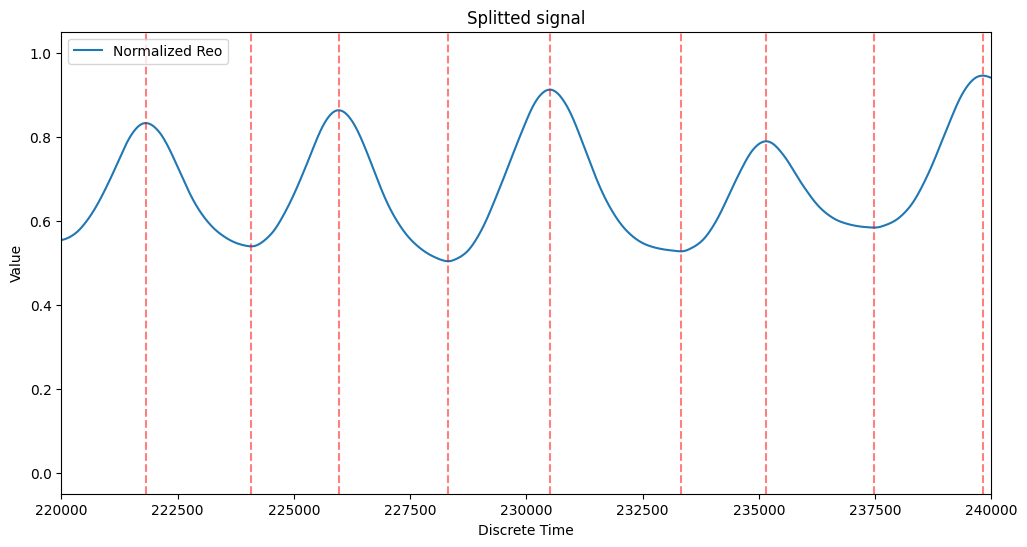

In [200]:
plt.figure(figsize=(12, 6))
plt.plot(normalized_reo_first, label='Normalized Reo')

for point in split_points_first:
    plt.axvline(x=point, color='r', linestyle='--', alpha=0.5)

plt.title('Splitted signal')
plt.xlabel('Discrete Time')
plt.ylabel('Value')
plt.legend()
plt.xlim([220000, 240000])
plt.show()

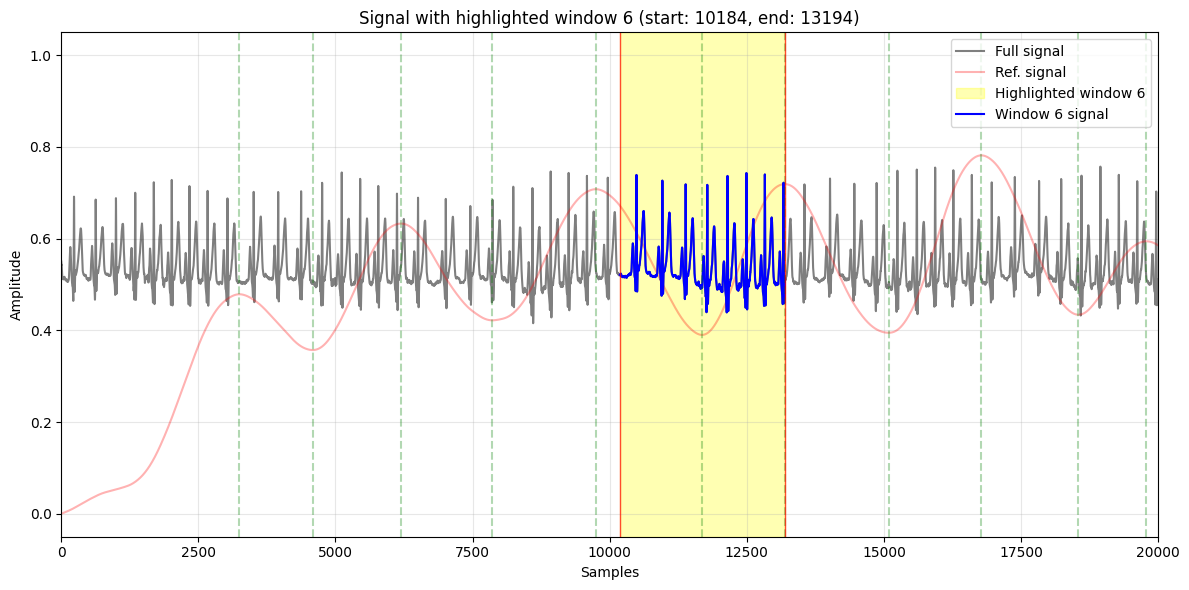

In [272]:
from matplotlib.colors import LinearSegmentedColormap

def split_by_reference_points(signal, reference_points, overlap_samples=0):
	"""
	Разбивает сигнал на сегменты по заданным референсным точкам с возможным перекрытием
	
	Параметры:
		signal (np.array): Входной сигнал
		reference_points (list): Список точек разбиения (индексы)
		overlap_samples (int): Количество samples перекрытия между соседними окнами.
							Если 0 - перекрытия нет.
	
	Возвращает:
		list: Список кортежей (сегмент, начало, конец)
		list: Список всех точек разбиения (с учетом перекрытия)
	"""
	segments = []
	adjusted_points = [0]  
	main_points = sorted(reference_points)
	
	for i in range(len(main_points)-1):
		start = main_points[i]
		end = main_points[i+1]
		
		if i > 0 and overlap_samples > 0:
			start = max(0, start - overlap_samples)
		
		# if i < len(main_points)-2:
			# end = min(len(signal) - 1, end + overlap_samples)
		
		segment = signal[start:end]
		segments.append((segment, start, end))
		
		if i < len(main_points)-2:  
			adjusted_points.append(end)
	
	adjusted_points.append(len(signal)-1)
	
	return segments, adjusted_points

def plot_signal_with_highlighted_window(signal, signal_ref, reference_points, window_index=0, overlap_samples=0):
	"""
	Визуализирует сигнал с подсветкой указанного окна
	
	Параметры:
		signal (np.array): Входной сигнал
		signal_ref (np.array): Референсный сигнал для сравнения
		reference_points (list): Список точек разбиения
		window_index (int): Индекс окна для подсветки (начиная с 0)
		overlap_samples (int): Количество samples перекрытия между окнами
	"""
	segments, adjusted_points = split_by_reference_points(signal, reference_points, overlap_samples)
	
	if window_index >= len(segments):
		raise ValueError(f"Window index {window_index} is out of range. Total windows: {len(segments)}")
	
	plt.figure(figsize=(12, 6))
	plt.plot(signal, color='black', alpha=0.5, label='Full signal')
	plt.plot(signal_ref, color='red', alpha=0.3, label='Ref. signal')

	segment, start, end = segments[window_index]
	x_values = np.arange(start, end)
	
	plt.axvspan(start, end, color='yellow', alpha=0.3, label=f'Highlighted window {window_index}')
	plt.plot(x_values, segment, color='blue', linewidth=1.5, label=f'Window {window_index} signal')
	for i, point in enumerate(adjusted_points):
		if i == 0 or i == len(adjusted_points)-1:
			continue 
		plt.axvline(x=point, color='green', linestyle='--', alpha=0.3)
	
	plt.axvline(x=start, color='red', linestyle='-', alpha=0.7, linewidth=1)
	plt.axvline(x=end, color='red', linestyle='-', alpha=0.7, linewidth=1)
	
	plt.title(f'Signal with highlighted window {window_index} (start: {start}, end: {end})')
	plt.xlabel('Samples')
	plt.ylabel('Amplitude')
	plt.legend(loc='upper right')
	plt.grid(True, alpha=0.3)
	plt.xlim([0, 20000])  
	
	plt.tight_layout()
	plt.show()

plot_signal_with_highlighted_window(normalized_signal_ecg_fourth,
									normalized_reo_fourth,
									split_points_fourth,
									window_index=6,
									overlap_samples=1500)

In [273]:
segments_ecg_first, adjusted_points_second = split_by_reference_points(normalized_signal_ecg_first, split_points_first,
                                                           overlap_samples=1500)

segments_ecg_second, adjusted_points_second = split_by_reference_points(normalized_signal_ecg_second, split_points_second,
                                                           overlap_samples=1500)

segments_ecg_third, adjusted_points_third = split_by_reference_points(normalized_signal_ecg_third, split_points_third,
                                                           overlap_samples=1500)

segments_ecg_fourth, adjusted_points_fourth = split_by_reference_points(normalized_signal_ecg_fourth, split_points_fourth,
                                                           overlap_samples=1500)
# len(segments), len(windows)

Контроль размерностей

In [274]:
len(segments_ecg_first), len(windows_first)

(115, 115)

In [275]:
len(segments_ecg_second), len(windows_second)

(247, 247)

In [276]:
len(segments_ecg_third), len(windows_third)

(223, 223)

In [277]:
len(segments_ecg_fourth), len(windows_fourth)

(81, 81)

Получим ```wavelet-спектрограммы```

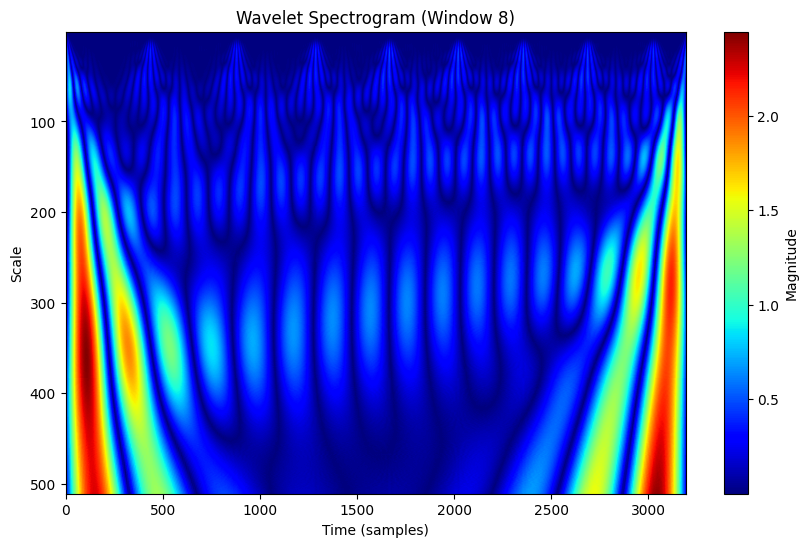

In [287]:
def plot_wavelet_spectrogram(signal_window, title="Wavelet Spectrogram", plot = True):
	wavelet = 'morl'
	scales = np.arange(1, 512)  
	coefficients, frequencies = pywt.cwt(signal_window, scales, wavelet)
	spec = np.abs(coefficients)
	spec = (spec - spec.min()) / (spec.max() - spec.min())
	if plot:
		plt.figure(figsize=(10, 6))
		plt.imshow(np.abs(coefficients), aspect='auto', cmap='jet',
				extent=[0, len(signal_window), scales[-1], scales[0]])
		plt.colorbar(label="Magnitude")
		plt.title(title)
		plt.xlabel("Time (samples)")
		plt.ylabel("Scale")

	return spec
    
window_index = 8
win_data, _, _ = segments_ecg_fourth[window_index]
# win_data = windows_first[window_index]

spec = plot_wavelet_spectrogram(win_data, title=f"Wavelet Spectrogram (Window {window_index})")

Посмотрим на матрицу спектрограммы

In [288]:
spec.shape

(511, 3193)

Далее нужно сформировать датасет пар: ```спектрограмма участка ЭКГ``` <-> ```Спектрограмма оригинального сигнала```

Идея будет заключаться в сближении эмбеддингов спектрограмм ЭКГ, соответствующих фазе вдоха и фазе выдоха

In [290]:
output_dir = "/Users/chervonikov_alexey/Desktop/bmstu_final/diploma/ecg_data/images_with_labels_padded_signal_only_512_scales_overlap_1500_back"
from tqdm import tqdm

def pad_signal(signal, target_length, pad_value=0):
	"""Добавляет симметричный паддинг к сигналу до target_length"""
	if len(signal) >= target_length:
		return signal[:target_length]
	else:
		total_pad = target_length - len(signal)
		pad_left = total_pad // 2
		pad_right = total_pad - pad_left  
		return np.pad(signal, (pad_left, pad_right), 'constant', constant_values=pad_value)

def pad_spectrogram(spec, target_length, pad_value=0):
	current_length = spec.shape[1]
	if current_length >= target_length:
		return spec[:, :target_length]  
	else:
		total_pad = target_length - current_length
		pad_left = total_pad // 2
		pad_right = total_pad - pad_left
		return np.pad(spec, ((0, 0), (pad_left, pad_right)), 'constant', constant_values=pad_value)

def plot_wavelet_spectrogram(signal_window, title="Wavelet Spectrogram", plot=True, target_length=None):
	wavelet = 'morl'
	scales = np.arange(1, 512)
	
	if target_length is not None:
		signal_window = pad_signal(signal_window, target_length)
	
	coefficients, frequencies = pywt.cwt(signal_window, scales, wavelet)
	spec = np.abs(coefficients)
	spec = (spec - spec.min()) / (spec.max() - spec.min())
	
	# if target_length is not None:
	# 	spec = pad_spectrogram(spec, target_length) 
	
	if plot:
		plt.figure(figsize=(10, 6))
		plt.imshow(spec, aspect='auto', cmap='jet',
				extent=[0, len(signal_window), scales[-1], scales[0]])
		plt.colorbar(label="Magnitude")
		plt.title(title)
		plt.xlabel("Time (samples)")
		plt.ylabel("Scale")
		plt.show()
	
	return spec

def save_spectrogram_data(spec, path, save_image=True, save_matrix=True):
	if save_image:
		plt.figure(figsize=(10, 6))
		plt.imshow(spec, aspect='auto', cmap='jet')
		plt.axis('off')  
		plt.savefig(path + '.jpeg', bbox_inches='tight', pad_inches=0, dpi=100)
		plt.close()
	
	if save_matrix:
		np.savez_compressed(path + '.npz', spec=spec)


def extract_images_from_signals(segments_ecg, windows_reo, labels, idx, output_dir, target_length=3500):
	os.makedirs(os.path.join(output_dir, 'ecg/images'), exist_ok=True)
	os.makedirs(os.path.join(output_dir, 'ecg/matrices'), exist_ok=True)
	os.makedirs(os.path.join(output_dir, 'reo/images'), exist_ok=True)
	os.makedirs(os.path.join(output_dir, 'reo/matrices'), exist_ok=True)
	
	for i, (reo, ecg, label) in enumerate(zip(windows_reo, segments_ecg, labels)):
		ecg_signal = ecg[0] if isinstance(ecg, tuple) else ecg
		spec_ecg = plot_wavelet_spectrogram(ecg_signal, plot=False, target_length=target_length)
		
		spec_reo = plot_wavelet_spectrogram(reo, plot=False, target_length=target_length)
		
		ecg_image_path = os.path.join(output_dir, 'ecg/images', f'ecg_window_{i}_{idx}_{label}')
		ecg_matrix_path = os.path.join(output_dir, 'ecg/matrices', f'ecg_window_{i}_{idx}_{label}')
		save_spectrogram_data(spec_ecg, ecg_image_path, save_matrix=False)
		save_spectrogram_data(spec_ecg, ecg_matrix_path, save_image=False)
		
		reo_image_path = os.path.join(output_dir, 'reo/images', f'reo_window_{i}_{idx}_{label}')
		reo_matrix_path = os.path.join(output_dir, 'reo/matrices', f'reo_window_{i}_{idx}_{label}')
		save_spectrogram_data(spec_reo, reo_image_path, save_matrix=False)
		save_spectrogram_data(spec_reo, reo_matrix_path, save_image=False)
		
		if i % 10 == 0:
			print(f'Processed {i+1} windows...')


segments_windows = [(segments_ecg_first, windows_first, labels_first), 
					(segments_ecg_second, windows_second, labels_second),
					(segments_ecg_third, windows_third, labels_third),
					(segments_ecg_fourth, windows_fourth, labels_fourth)]

for idx, (segments, windows, labels) in tqdm(enumerate(segments_windows)):
	extract_images_from_signals(segments_ecg=segments,
								windows_reo=windows, 
								output_dir=output_dir,
								labels=labels, 
								idx=idx)
		
	

0it [00:00, ?it/s]

Processed 1 windows...
Processed 11 windows...
Processed 21 windows...
Processed 31 windows...
Processed 41 windows...
Processed 51 windows...
Processed 61 windows...
Processed 71 windows...
Processed 81 windows...
Processed 91 windows...
Processed 101 windows...
Processed 111 windows...


1it [14:45, 885.53s/it]

Processed 1 windows...
Processed 11 windows...
Processed 21 windows...
Processed 31 windows...
Processed 41 windows...
Processed 51 windows...
Processed 61 windows...
Processed 71 windows...
Processed 81 windows...
Processed 91 windows...
Processed 101 windows...
Processed 111 windows...
Processed 121 windows...
Processed 131 windows...
Processed 141 windows...
Processed 151 windows...
Processed 161 windows...
Processed 171 windows...
Processed 181 windows...
Processed 191 windows...
Processed 201 windows...
Processed 211 windows...
Processed 221 windows...
Processed 231 windows...
Processed 241 windows...


2it [1:13:31, 2438.97s/it]

Processed 1 windows...
Processed 11 windows...
Processed 21 windows...
Processed 31 windows...
Processed 41 windows...
Processed 51 windows...
Processed 61 windows...
Processed 71 windows...
Processed 81 windows...
Processed 91 windows...
Processed 101 windows...
Processed 111 windows...
Processed 121 windows...
Processed 131 windows...
Processed 141 windows...
Processed 151 windows...
Processed 161 windows...
Processed 171 windows...
Processed 181 windows...
Processed 191 windows...
Processed 201 windows...
Processed 211 windows...
Processed 221 windows...


3it [1:49:40, 2315.62s/it]

Processed 1 windows...
Processed 11 windows...
Processed 21 windows...
Processed 31 windows...
Processed 41 windows...
Processed 51 windows...
Processed 61 windows...
Processed 71 windows...


4it [1:59:15, 1788.86s/it]

Processed 81 windows...


Контроль количества изображений

In [291]:
folder_path = '/Users/chervonikov_alexey/Desktop/bmstu_final/diploma/ecg_data/images_with_labels_padded_signal_only_512_scales_overlap_100/ecg/matrices'

files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
num_files = len(files)

print(f"Количество файлов: {num_files}")

Количество файлов: 666


In [292]:
folder_path = '/Users/chervonikov_alexey/Desktop/bmstu_final/diploma/ecg_data/images_with_labels_padded_signal_only_512_scales_overlap_100/reo/matrices'

files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
num_files = len(files)

print(f"Количество файлов: {num_files}")

Количество файлов: 666


В распоряжении 666 изображений для обучения